## Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

## Load data and introduce non-linearity

Our electromagnet model provides linear relationship between the voltage and field. In order to explore non-linear relationship, we need to introduce non-linearity by hand. We will do it  by applying tanh element-wise to the field values.

In [2]:
#Training data
df = pd.read_csv('data/individual_calibration_set.csv')

Bx, By, Bz = df['B_x'].to_numpy(), df['B_y'].to_numpy(), df['B_z'].to_numpy() # Extract fields
V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

# Introduce non-linearity
nf = 15 # Non-linearity factor
Bx, By, Bz = np.tanh(Bx/nf)*np.max(Bx), np.tanh(By/nf)*np.max(By), np.tanh(Bz/nf)*np.max(Bz)

# Stack data for the network
B_train = np.stack((Bx, By, Bz), axis=1)
V_train = np.stack((V1, V2, V3), axis=1)

In [3]:
#Validation data
df_val = pd.read_csv('data/validation_set.csv')

Bx_val, By_val, Bz_val = df_val['B_x'].to_numpy(), df_val['B_y'].to_numpy(), df_val['B_z'].to_numpy() # Extract fields
V1_val, V2_val, V3_val = df_val['V_1'].to_numpy(), df_val['V_2'].to_numpy(), df_val['V_3'].to_numpy()  # Extract voltages

# Introduce non-linearity
nf = 15 # Non-linearity factor
Bx_val, By_val, Bz_val = np.tanh(Bx_val/nf)*np.max(Bx_val), np.tanh(By_val/nf)*np.max(By_val), np.tanh(Bz_val/nf)*np.max(Bz_val)

# Stack data for the network
B_val = np.stack((Bx_val, By_val, Bz_val), axis=1)
V_val = np.stack((V1_val, V2_val, V3_val), axis=1)

## Plot non-linear data

In [4]:
def B_vs_V(x:np.array, y1:np.array, y2:np.array, y3:np.array):
    """plots y1, y2, and y3 vs x and returns the corresponding slopes"""
    index = x != 0 # Indexes for which v is non-zero
    x, y1, y2, y3 = x[index], y1[index], y2[index], y3[index] # Values for which v is non-zero

    # Plot
    fig, ax = plt.subplots()
    ax.plot(x, y1, label=r'$B_x$', linewidth=4.0)
    ax.plot(x, y2, label=r'$B_y$', linewidth=4.0)
    ax.plot(x, y3, label=r'$B_z$', linewidth=4.0)
    ax.set_xlabel(r'$V_1$ (arb. u.)')
    ax.set_ylabel('Field (arb. u.)' )
    #ax.set_xlim(0,1)
    ax.legend(loc=0)
    ax.grid()
    return ax

<AxesSubplot:xlabel='$V_1$ (arb. u.)', ylabel='Field (arb. u.)'>

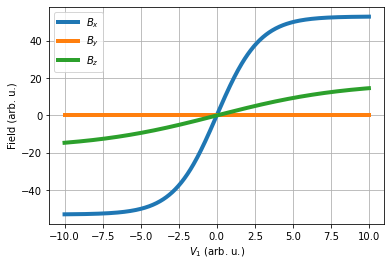

In [5]:
B_vs_V(V1, Bx, By, Bz)

Text(0.5, 0, '$V_2$ (arb. u.)')

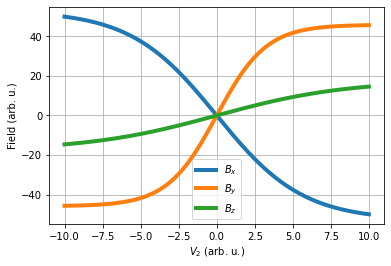

In [6]:
ax2 = B_vs_V(V2, Bx, By, Bz)
ax2.set_xlabel(r'$V_2$ (arb. u.)')

Text(0.5, 0, '$V_3$ (arb. u.)')

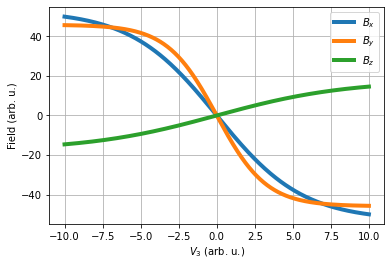

In [7]:
ax3 = B_vs_V(V3, Bx, By, Bz)
ax3.set_xlabel(r'$V_3$ (arb. u.)')

## 'Deep' learning

In [8]:
# Import full calibration set
df = pd.read_csv('data/full_calibration_set.csv')

Bx, By, Bz = df['B_x'].to_numpy(), df['B_y'].to_numpy(), df['B_z'].to_numpy() # Extract fields
V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

# Introduce non-linearity
nf = 15 # Non-linearity factor
Bx, By, Bz = np.tanh(Bx/nf)*np.max(Bx), np.tanh(By/nf)*np.max(By), np.tanh(Bz/nf)*np.max(Bz)

# Stack data for the network
B_train = np.stack((Bx, By, Bz), axis=1)
V_train = np.stack((V1, V2, V3), axis=1)

In [17]:
# Initialize model
model = keras.models.Sequential([
    keras.layers.Dense(3),
    keras.layers.Dense(8,activation='relu'),
    keras.layers.Dense(3)
])

In [18]:
# Compile model
model.compile(loss="mse", optimizer = keras.optimizers.Adam(), metrics=["mae"])

In [19]:
# Add callbacks

# Stops training if the mean absolute error does not improve for 300 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_mae',restore_best_weights=True)
# Saves the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="models.hdf5",save_best_only=True, monitor='val_mae')

In [20]:
# Train model
history = model.fit(B_train, V_train, epochs=1000, validation_data=(B_val, V_val),batch_size=8,callbacks=[checkpoint_cb, early_stopping_cb]);

Epoch 1/1000
313/313 [==============================] - 0s 933us/step - loss: 290.9200 - mae: 11.0482 - val_loss: 72.1508 - val_mae: 6.1248
Epoch 2/1000
313/313 [==============================] - 0s 599us/step - loss: 29.3990 - mae: 3.7217 - val_loss: 24.1217 - val_mae: 3.9212
Epoch 3/1000
313/313 [==============================] - 0s 548us/step - loss: 9.6612 - mae: 2.2599 - val_loss: 14.7805 - val_mae: 3.1041
Epoch 4/1000
313/313 [==============================] - 0s 531us/step - loss: 5.9483 - mae: 1.7703 - val_loss: 11.7154 - val_mae: 2.7228
Epoch 5/1000
313/313 [==============================] - 0s 553us/step - loss: 4.5357 - mae: 1.5226 - val_loss: 10.5827 - val_mae: 2.5635
Epoch 6/1000
313/313 [==============================] - 0s 585us/step - loss: 3.8841 - mae: 1.3814 - val_loss: 9.6932 - val_mae: 2.4261
Epoch 7/1000
313/313 [==============================] - 0s 638us/step - loss: 3.5062 - mae: 1.2964 - val_loss: 8.8835 - val_mae: 2.3108
Epoch 8/1000
313/313 [=================

(0.0, 5.0)

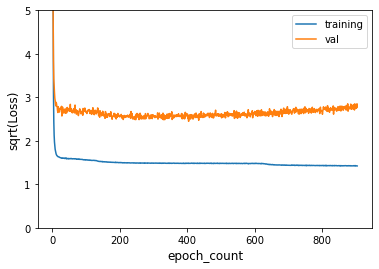

In [22]:
# Plot training process

h = history.history

training_loss = np.array(h["loss"])
test_loss = np.array(h["val_loss"])
epoch_count = np.arange(len(training_loss)) + 1

fig, ax = plt.subplots()
ax.plot(epoch_count, np.sqrt(training_loss), label='training')
ax.plot(epoch_count, np.sqrt(test_loss), label='val')
ax.set_xlabel(r'epoch_count', fontsize=12)
ax.set_ylabel(r'sqrt(Loss)', fontsize=12)
ax.legend(loc=0)
ax.set_ylim(0, 5)